In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(40)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [3]:
SIZE=64

In [4]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id     dx    dx_type   age     sex  \
8296  HAM_0001525  ISIC_0025662     nv      histo  35.0    male   
1324  HAM_0002471  ISIC_0028326    mel      histo  40.0  female   
4457  HAM_0007404  ISIC_0030295     nv  follow_up  50.0  female   
3619  HAM_0004678  ISIC_0025952     nv  follow_up  50.0    male   
6098  HAM_0000436  ISIC_0026547     nv  follow_up  45.0    male   
5105  HAM_0003180  ISIC_0031058     nv  follow_up  40.0    male   
9889  HAM_0005231  ISIC_0029043  akiec      histo  70.0    male   
3530  HAM_0002283  ISIC_0028869     nv  follow_up  40.0  female   
6750  HAM_0003230  ISIC_0027640     nv      histo  45.0    male   
8015  HAM_0005489  ISIC_0033851     nv      histo  60.0    male   

         localization  label  
8296  upper extremity      5  
1324  lower extremity      4  
4457            trunk      5  
3619  lower extremity      5  
6098            trunk      5  
5105  upper extremity      5  
9889  lower extremity      0  
3530  lower ex

In [6]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [7]:
skin_df_l0 = skin_df[skin_df['label'] == 0]
skin_df_l1 = skin_df[skin_df['label'] == 1]
skin_df_l2 = skin_df[skin_df['label'] == 2]
skin_df_l3 = skin_df[skin_df['label'] == 3]
skin_df_l4 = skin_df[skin_df['label'] == 4]
skin_df_l5 = skin_df[skin_df['label'] == 5]
skin_df_l6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=500 
skin_df_l0_balanced = resample(skin_df_l0, replace=True, n_samples=n_samples, random_state=42) 
skin_df_l1_balanced = resample(skin_df_l1, replace=True, n_samples=n_samples, random_state=42) 
skin_df_l2_balanced = resample(skin_df_l2, replace=True, n_samples=n_samples, random_state=42)
skin_df_l3_balanced = resample(skin_df_l3, replace=True, n_samples=n_samples, random_state=42)
skin_df_l4_balanced = resample(skin_df_l4, replace=True, n_samples=n_samples, random_state=42)
skin_df_l5_balanced = resample(skin_df_l5, replace=True, n_samples=n_samples, random_state=42)
skin_df_l6_balanced = resample(skin_df_l6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
skin_df_balanced = pd.concat([skin_df_l0_balanced, skin_df_l1_balanced, 
                              skin_df_l2_balanced, skin_df_l3_balanced, 
                              skin_df_l4_balanced, skin_df_l5_balanced, skin_df_l6_balanced])

In [10]:
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [11]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [12]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=40)

In [14]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

In [15]:
batch_size = 32 
epochs = 100

In [16]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)


Epoch 1/100
83/83 - 43s - loss: 1.9283 - acc: 0.1703 - val_loss: 1.8052 - val_acc: 0.2343 - 43s/epoch - 517ms/step
Epoch 2/100
83/83 - 42s - loss: 1.7694 - acc: 0.2480 - val_loss: 1.7648 - val_acc: 0.2857 - 42s/epoch - 504ms/step
Epoch 3/100
83/83 - 42s - loss: 1.6356 - acc: 0.3227 - val_loss: 1.8535 - val_acc: 0.3211 - 42s/epoch - 502ms/step
Epoch 4/100
83/83 - 42s - loss: 1.5068 - acc: 0.3874 - val_loss: 1.4825 - val_acc: 0.4069 - 42s/epoch - 503ms/step
Epoch 5/100
83/83 - 43s - loss: 1.4199 - acc: 0.4331 - val_loss: 1.4690 - val_acc: 0.4240 - 43s/epoch - 514ms/step
Epoch 6/100
83/83 - 42s - loss: 1.3943 - acc: 0.4499 - val_loss: 1.3713 - val_acc: 0.4891 - 42s/epoch - 506ms/step
Epoch 7/100
83/83 - 42s - loss: 1.3544 - acc: 0.4636 - val_loss: 1.4416 - val_acc: 0.4046 - 42s/epoch - 504ms/step
Epoch 8/100
83/83 - 42s - loss: 1.2767 - acc: 0.4945 - val_loss: 1.4654 - val_acc: 0.4309 - 42s/epoch - 504ms/step
Epoch 9/100
83/83 - 42s - loss: 1.3236 - acc: 0.4800 - val_loss: 1.4067 - val_ac

Epoch 72/100
83/83 - 46s - loss: 0.3715 - acc: 0.8579 - val_loss: 0.8141 - val_acc: 0.7886 - 46s/epoch - 552ms/step
Epoch 73/100
83/83 - 46s - loss: 0.3454 - acc: 0.8693 - val_loss: 0.7869 - val_acc: 0.7954 - 46s/epoch - 553ms/step
Epoch 74/100
83/83 - 46s - loss: 0.3570 - acc: 0.8750 - val_loss: 0.8036 - val_acc: 0.7920 - 46s/epoch - 559ms/step
Epoch 75/100
83/83 - 46s - loss: 0.3918 - acc: 0.8610 - val_loss: 0.8105 - val_acc: 0.7737 - 46s/epoch - 551ms/step
Epoch 76/100
83/83 - 46s - loss: 0.3440 - acc: 0.8766 - val_loss: 0.8479 - val_acc: 0.7783 - 46s/epoch - 550ms/step
Epoch 77/100
83/83 - 46s - loss: 0.4214 - acc: 0.8476 - val_loss: 0.8184 - val_acc: 0.7691 - 46s/epoch - 552ms/step
Epoch 78/100
83/83 - 46s - loss: 0.3775 - acc: 0.8636 - val_loss: 0.8500 - val_acc: 0.7737 - 46s/epoch - 553ms/step
Epoch 79/100
83/83 - 46s - loss: 0.3727 - acc: 0.8651 - val_loss: 0.7939 - val_acc: 0.7771 - 46s/epoch - 551ms/step
Epoch 80/100
83/83 - 46s - loss: 0.3787 - acc: 0.8564 - val_loss: 0.7371

In [17]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 3s 102ms/step - loss: 0.8296 - acc: 0.8069
Test accuracy: 0.806857168674469


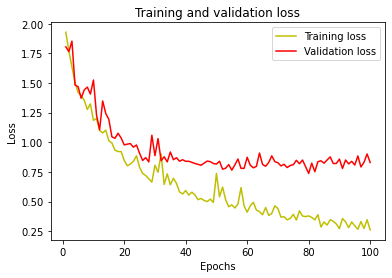

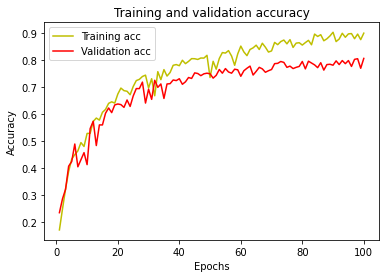

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


28/28 [==============================] - 3s 94ms/step


In [20]:
cm = confusion_matrix(y_true, y_pred_classes)

<AxesSubplot:>

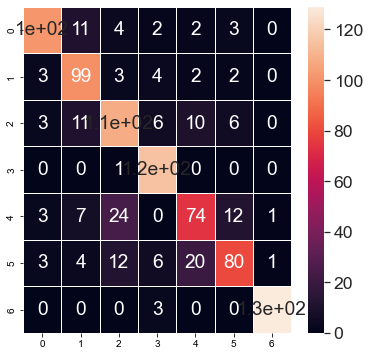

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [26]:

model.save("HAM10000_2.keras")


import pickle

with open("training_history.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)


In [47]:
def preprocess_image(image_path):
    img = Image.open(image_path).resize((SIZE, SIZE))
    img_array = np.array(img) 
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

In [48]:
def predict_class(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    class_idx = np.argmax(predictions)
    return class_idx

In [49]:
image_path = "C:/Users/Harshith/Downloads/akiec_image.jpg"  

predicted_class_idx = predict_class(image_path)

class_labels = ['Class0', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']

predicted_class_label = class_labels[predicted_class_idx]

print(f'The predicted class is: {predicted_class_label}')

1/1 [==============================] - 0s 28ms/step
The predicted class is: Class1
